In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from skimage.morphology import flood, binary_closing, disk
from skimage import img_as_ubyte

In [89]:
input_folder = '../MSFD/1/face_crop' # cropped faces with mask
output_folder = '../output/part_c' # Path to the folder where you want the output segemented images to be saved
ground_truth_folder= '../MSFD/1/face_crop_segmentation' # folder that contains actual face mask

In [95]:
def segment_mask_region(image_path, viz = False, to_save = False, save_separetely = None):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 8)

    # Compute Gradient for Additional Feature
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Extract features (Intensity, Spatial Location, Gradient)
    height, width = gray.shape
    X_features = []
    for y in range(height):
        for x in range(width):
            X_features.append([gray[y, x], x / width, y / height, gradient_magnitude[y, x]])

    X_features = np.array(X_features)

    # Manual Seed Selection
    center_x, center_y = width // 2, height // 2
    seed1 = [gray[center_y, center_x], center_x / width, center_y / height, gradient_magnitude[center_y, center_x]]
    seed2 = [gray[0, 0], 0, 0, gradient_magnitude[0, 0]]  # Top-left corner as background

    # Apply K-Means with Manual Seeds
    kmeans = KMeans(n_clusters=2, init=np.array([seed1, seed2]), n_init=1, max_iter=100, random_state=42)
    labels = kmeans.fit_predict(X_features)
   
    # Invert if needed (as Mask should always be white)
    #if kmeans.cluster_centers_[0][0] > kmeans.cluster_centers_[1][0]:  
    labels = 1 - labels  # Swap labels

    #print(kmeans.cluster_centers_)
    #print(f'{type(labels)}, {len(labels)}')


    # Reshaping the labels to match the image shape
    segmented_image = labels.reshape((height, width))

    # Convert segmented image to uint8 (0-255 range)
    segmented_display = (segmented_image * 255).astype(np.uint8)

    # Ensuring binary segmentation before Canny
    segmented_display = cv2.threshold(segmented_display, 127, 255, cv2.THRESH_BINARY)[1]

    # Morphological Closing to Refine Segmentation
    kernel = np.ones((5, 5), np.uint8)
    segmented_display = cv2.morphologyEx(segmented_display, cv2.MORPH_CLOSE, kernel)

    # Applying Canny Edge Detection
    edges = cv2.Canny(segmented_display, 50, 150)

    if(viz==True):

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display Original Image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Display Segmented Region (Fix Scaling Issue)
        axes[1].imshow(segmented_display, cmap="gray", vmin=0, vmax=255)
        axes[1].set_title("Segmented Mask Region")
        axes[1].axis("off")

        # Display Edge Detection Result
        axes[2].imshow(edges, cmap="gray", vmin=0, vmax=255)
        axes[2].set_title("Edges of Segmentation")
        axes[2].axis("off")

        plt.show()
    
    if(to_save == True):
        if(save_separetely != None):
            cv2.imwrite(os.path.join(output_folder, image_path), segmented_display)
        else:
            os.makedirs(output_folder, exist_ok=True)
            cv2.imwrite(os.path.join(output_folder, image_path), segmented_display)

    return segmented_display

def segment_region_growing(image_path, tolerance=0.4, viz=False, to_save=False, save_path=None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    
    # Convert to grayscale & apply Gaussian Blur
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (17, 17), 8)

    # Normalize image to [0,1] for flood fill
    norm_image = blurred.astype(np.float32) / 255.0  

    # Define seed point at image center
    height, width = norm_image.shape
    seed_point = (height // 2, width // 2)
    
    # Perform region growing using flood fill
    mask = flood(norm_image, seed_point, tolerance=tolerance)
    
    # Convert mask to uint8 binary image (0 or 255)
    segmented_display = img_as_ubyte(mask)

    # Apply morphological closing to refine segmentation
    segmented_display = binary_closing(segmented_display, disk(3)).astype(np.uint8) * 255

    # Detect edges using Canny
    edges = cv2.Canny(segmented_display, 50, 150)

    # Visualization
    if viz:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(segmented_display, cmap="gray")
        axes[1].set_title("Segmented Region")
        axes[1].axis("off")

        axes[2].imshow(edges, cmap="gray")
        axes[2].set_title("Edges of Segmentation")
        axes[2].axis("off")

        plt.show()
    
    # Save result if needed
    if to_save:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, segmented_display)

    return segmented_display

def compute_metrics(pred_mask, true_mask_path):
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if true_mask is None:
        raise ValueError(f"Error: Could not load {true_mask_path}")

    # Convert to binary masks
    pred_mask = (pred_mask > 0).astype(np.uint8)
    true_mask = (true_mask > 0).astype(np.uint8)

    # Compute IoU
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union > 0 else 0

    # Compute Dice
    dice = (2 * intersection) / (pred_mask.sum() + true_mask.sum()) if (pred_mask.sum() + true_mask.sum()) > 0 else 0

    return {"IoU": iou, "Dice": dice}

To test on individual images:

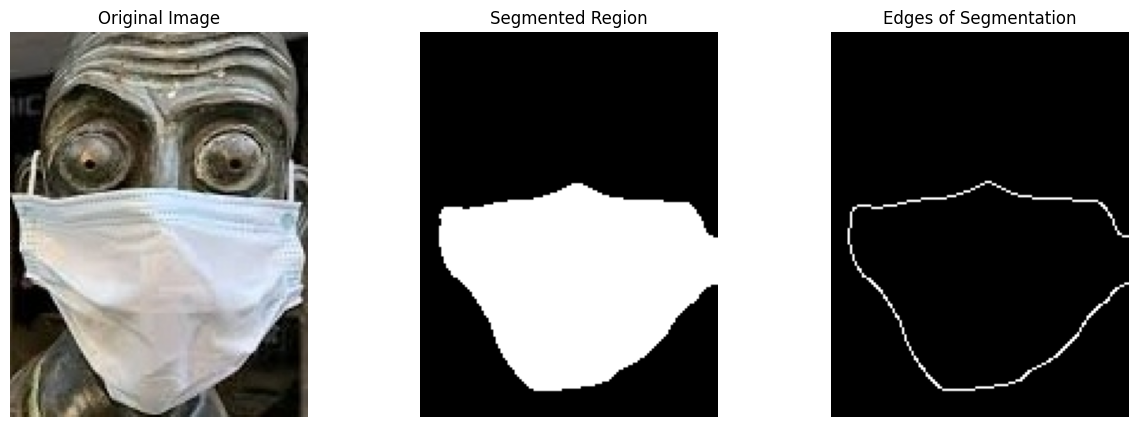

{'IoU': np.float64(0.7595030792100234), 'Dice': np.float64(0.8633154305714803)}


In [91]:
#pred_mask = segment_mask_region('../MSFD/1/face_crop/000007_1.jpg', viz=True)
pred_mask = segment_region_growing(image_path='../MSFD/1/face_crop/000007_1.jpg', viz=True, tolerance=0.19)
true_mask_path = '../MSFD/1/face_crop_segmentation/000007_1.jpg'
print(compute_metrics(pred_mask, true_mask_path))

In [97]:
avg_iou = 0
avg_dice = 0
count = 0  # Count of valid images

# Process each image
for img in os.listdir(input_folder):
    if img.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter images
        img_path = os.path.join(input_folder, img)
        gt_mask_path = os.path.join(ground_truth_folder, img)  # Assuming same filename

        if not os.path.exists(gt_mask_path):
            print(f"Skipping {img} (No ground truth found)")
            continue
        
        predicted_segment = segment_region_growing(image_path=img_path, tolerance=0.15)  # Generate mask
        
        # Load ground truth mask
        true_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        
        if true_mask is None:
            print(f"Skipping {img} (Cannot load ground truth mask)")
            continue
        
        # Check shape compatibility
        if predicted_segment.shape != true_mask.shape:
            print(f"Skipping {img} (Shape mismatch: {predicted_segment.shape} vs {true_mask.shape})")
            continue
        
        metrics = compute_metrics(predicted_segment, gt_mask_path)  # Compute IoU & Dice
        
        if metrics:  # If computation was successful
            avg_iou += metrics["IoU"]
            avg_dice += metrics["Dice"]
            count += 1  

if count > 0:
    avg_iou /= count
    avg_dice /= count
    print(f"\nAverage IoU: {avg_iou:.4f}, Average Dice: {avg_dice:.4f}")
else:
    print("\nNo valid images processed.")


Skipping 000601_1.jpg (No ground truth found)
Skipping 007541_1.jpg (Shape mismatch: (129, 172) vs (128, 172))

Average IoU: 0.3559, Average Dice: 0.4798
